# XRD Calibration
---

using diffraction patterns from database

$f = \dfrac{1}{f_{\max}}\displaystyle\sum_j f_j $

$f_j = I_j \gamma_j e^{\dfrac{-\frac{1}{2}(x-(\mu_j+\Delta_j))^2}{\sigma_j^2}}$

where $I$ is the intensity, $\gamma$ if correction to intensity 

$f = \dfrac{1}{f_{\max}}  \displaystyle\sum_j I_j \gamma_j e^{\dfrac{-\frac{1}{2}(x-(\mu_j+\Delta_j))^2}{\sigma_j^2}}$

$\dfrac{\partial f}{\partial \sigma^2_j} = \dfrac{\partial f_j}{\partial \sigma^2_j} - f_j\dfrac{1}{{f_\max}^2}\dfrac{\partial f_{\max}}{\partial \sigma^2_j} $

since $f_\max = 1$

$\dfrac{\partial f}{\partial \sigma^2_j} = \dfrac{\partial f_j}{\partial \sigma^2_j} - f_j\dfrac{\partial f_{\max}}{\partial \sigma^2_j} $

$\dfrac{\partial f_j}{\partial \sigma^2_j} = \dfrac{1}{2}\dfrac{[x-(\mu_j+\Delta_j)]^2}{\sigma_j^4}f_j$

following the above

$\dfrac{\partial f_j}{\partial \gamma_j} = I_j e^{\dfrac{-\frac{1}{2}(x-(\mu_j+\Delta_j))^2}{\sigma_j^2}} $

$\dfrac{\partial f_j}{\partial \Delta_j} = \dfrac{x - (\mu + \Delta)}{\sigma^2} f_j$


---
### notes

add Hessian matrix


---

Rewriting $x$ as a function of the calibration curve

$f_j = I_j \gamma_j e^{-\dfrac{\frac{1}{2}(g(\Omega;a,b,c,d)-\mu_j)^2}{\sigma_j^2}}$

here $\Omega$ denotes channels

$x \equiv g(\Omega) = a + b\Omega + c\Omega^2 + d\Omega^3$ 

$f_j = I_j \gamma_j e^{-\dfrac{\frac{1}{2}(a + b\Omega + c\Omega^2 + d\Omega^3-\mu_j)^2}{\sigma_j^2}}$

$\dfrac{\partial f_j}{\partial a} = -\dfrac{ 1}{\sigma_j^2}(a + b\Omega + c\Omega^2 + d\Omega^3 - \mu_j) f_j$

$= -\dfrac{ 1}{\sigma_j^2}(g(\Omega) - \mu_j) f_j$

$\dfrac{\partial f_j}{\partial b} = -\dfrac{ \Omega (g(\Omega) - \mu_j) }{\sigma_j^2}f_j  $

$\dfrac{\partial f_j}{\partial c} = -\dfrac{ \Omega^2 (g(\Omega) - \mu_j) }{\sigma_j^2}f_j  $

$\dfrac{\partial f_j}{\partial d} = -\dfrac{ \Omega^3 (g(\Omega) - \mu_j) }{\sigma_j^2}f_j  $


---
Geometric fucntion

$\theta = \dfrac{180}{\pi} \tan^{-1}\left(\dfrac{x + a}{s}\right) + \beta$



$x$ and $a$ in the units of channels. $s$ is also in the units of channels and it rescales the detector range.
$\beta[^\circ]$ is an angle.

$\dfrac{\partial\theta}{\partial s} = -\dfrac{180}{\pi} \dfrac{a+x}{a^2+2ax+s^2+x^2}= -\dfrac{180}{\pi} \dfrac{a+x}{(a+x)^2+s^2}$

$\dfrac{\partial\theta}{\partial a} = \dfrac{180}{\pi} \dfrac{s}{a^2+2ax+s^2+x^2} = \dfrac{180}{\pi} \dfrac{s}{(a+x)^2+s^2}$

$\dfrac{\partial\theta}{\partial \beta} = 1$

$\theta = \dfrac{180}{\pi}\left[ \tan^{-1}\left(\dfrac{x + a}{z\sin\left(\beta\right)}\right) + \beta\right]$

here $\beta$ is in radians

$\dfrac{\partial\theta}{\partial z} = -\dfrac{180}{\pi}\dfrac{(a + x) \csc(\beta)}{z^2 + (a + x)^2 \csc^2(\beta)}$

$\dfrac{\partial\theta}{\partial a} = \dfrac{180}{\pi}\dfrac{z \csc(\beta)}{z^2 + (a + x)^2 \csc^2(\beta))}$

$\dfrac{\partial\theta}{\partial \beta} = \dfrac{180}{\pi} \left[ 1 - \dfrac{z (a + x) \cot(\beta) \csc(\beta)}{z^2 + (a + x)^2 \csc^2(\beta)} \right]$

Rewriting $x$ as a function of the calibration curve

$f_j = I_j \gamma_j e^{-\dfrac{\frac{1}{2}(g(\Omega;a,b,s)-\mu_j)^2}{\sigma_j^2}}$

here $\Omega$ denotes channels

$x \equiv g(\Omega) = \dfrac{180}{\pi} \tan^{-1}\left(\dfrac{\Omega + a}{s}\right) + \beta$ 

$f_j = I_j \gamma_j e^{-\dfrac{\frac{1}{2}\left[\dfrac{180}{\pi} \tan^{-1}\left(\dfrac{\Omega + a}{s}\right) + \beta-\mu_j\right]^2}{\sigma_j^2}}$

$\dfrac{\partial f_j}{\partial a} = -\dfrac{ 1}{\sigma_j^2}\dfrac{\partial g(\Omega)}{\partial a}(g(\Omega) - \mu_j) f_j$

In [613]:
from src.database import DatabaseXRD,snip
from numpy import newaxis,loadtxt,diag,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

In [614]:
class Spectra():

    def __init__(self,file=None):
        if file:
            self.read_from_file(file)
            
        self.opt = array([-1264.,51.,2061.])
        self.a,self.beta,self.s = self.opt[:,newaxis]
    
    def read_from_file(self,file):
        
        self.raw_theta,self.raw_intensity = loadtxt(file,unpack=True)
        self.channel = arange(1280)
        
        self.intensity = self.raw_intensity/self.raw_intensity.max()
        
    def fce_calibration(self,x,a,beta,s):
        return (arctan((x+a)/s)) * 180 / pi + beta
    
    def fce_calibration_z(self,x,a,b,z):
        return (arctan((x+a)/(z*sin(b))) + b) * 180 / pi
    
    def calibrate_from_file(self,file):           
        
        x,y = loadtxt(file,unpack=True)
        self.opt,(opt_var) = curve_fit(self.fce_calibration,x,y)
        
        self.a,self.beta,self.s = self.opt[:,newaxis]
               
        return self
    
    @property
    def theta(self):
        return self.fce_calibration(self.channel,*self.opt)
    
    def snip(self,m = 24):

        y = self.intensity
        y = y - snip(y,m)
        self.intensity = y/y.max()
        
        return self
    
    def convolve(self,w=24):
        off = 4 * w
        kernel = signal.windows.gaussian(2*off-1,w)

        y = self.intensity
        y_pad = pad(y,(off,off),'edge')

        f = fft.rfft(y_pad)
        w = fft.rfft(kernel,y_pad.shape[-1])
        y = fft.irfft(w * f)

        y = y[off*2:]
        self.intensity = y/y.max()
        
        return self
    
    def plot(self, *args, **kwargs):

        plot(self.theta,self.intensity, *args, **kwargs)
        
        return self
        

In [615]:
class GaussNewton():
    
    def __init__(self,phase,spectra):
        
        if isinstance(phase,list):
            self.phase = phase
        else:
            self.phase = [phase]
            
        self.spectra = spectra
            
        self.mu = []
        self.intensity = []
        
        for phase in self.phase:
            #p.get_theta(l=[1.541,1.391],scale=[1.0,0.008])
            
            phase.get_theta(l=[1.541],scale=[1.0])  
            f = (phase.theta < 51) & (phase.intensity > 0.05)
            
            phase.f = f
        
            self.mu += list(phase.theta[f])
            self.intensity += list(phase.intensity[f])
            
        self.mu,self.intensity = array(sorted(zip(self.mu,self.intensity))).T
        
        self.n = len(self.mu)
        self.n_channel = len(self.channel)
        
        self.params = zeros(self.n * 2)
        self.sigma2 = self.params[:self.n]
        self.gamma = self.params[self.n:]
   
        self.sigma2[:] = 0.04
        self.gamma[:] = 1

    @property
    def theta(self):
        return self.spectra.theta
    
    @property
    def channel(self):
        return self.spectra.channel
        
    def gauss(self,x,mu,sigma2):
        return exp(-0.5 * (x - mu)**2 / sigma2)
    
    def dsigma2(self,x,mu,sigma2):
        return 0.5 * (x - mu)**2 / sigma2**2
    
    def da(self,channel,x,a,s,mu,sigma2):
        return -1.0 / sigma2 * 180 / pi * s / ((a + channel)**2 + s**2) * (x - mu)
    
    def ds(self,channel,x,a,s,mu,sigma2):
        return 1.0 / sigma2 * 180 / pi * (a + channel) / ((a + channel)**2 + s**2) * (x - mu)
    
    def dbeta(self,x,mu,sigma2):
        return -1.0 / sigma2 * (x - mu)
    
    @property
    def z(self):
        
        y = zeros(len(self.channel))
        x = self.theta
        
        """
        Loop over all peaks
        """
        for mu,I,sigma2,gamma in zip(self.mu,self.intensity,self.sigma2,self.gamma):

            c = self.gauss(x,mu,sigma2)
            h = gamma * I * c
            
            y += h
            
        return y/y.max()

    def plot(self,*args,**kwargs):
        
        plot(self.theta,self.z,*args,**kwargs)
        
        return self
    
    def loop(self):
        
        dsigma2 = []
        dgamma = []
        
        dopt = zeros((3,len(self.spectra.channel)))     
        da,dbeta,ds = dopt[:]
        
        z = zeros(self.n_channel)
        x = self.theta
        
        for mu,I,sigma2,gamma in zip(self.mu,self.intensity,self.sigma2,self.gamma):

            c = self.gauss(x,mu,sigma2)
            h = gamma * I * c
            
            """
            current z
            """
            z += h
            
            dsigma2 += [h * self.dsigma2(x,mu,sigma2)]
            dgamma += [I * c]
            
            da += h * self.da(self.channel,x,*self.spectra.a,*self.spectra.s,mu,sigma2)
            dbeta += h * self.dbeta(x,mu,sigma2)
            ds += h * self.ds(self.channel,x,*self.spectra.a,*self.spectra.s,mu,sigma2)
        
        return z/z.max(),dsigma2,dgamma,dopt
    
    @staticmethod
    def inv(d,y,z):
        
        jmax = z.argmax()
        dz = y - z
               
        dfmax = z[:,newaxis] * d[jmax] / z[jmax,newaxis]**2
        d = d - dfmax

        return pinv(d) @ dz  
        
    
    def minimize_gamma(self,alpha = 1):

        y = self.spectra.intensity
        z,dsigma2,dgamma,dopt  = self.loop()
        
        d = dgamma
        d = array(d).T
        
        dr = self.inv(d,y,z)
   
        self.gamma[:] += dr * alpha
    
    def rescale(self,dr,alpha):
        
        c = 1
        new_sigma2 = self.sigma2 + dr * alpha * c
        
        while any(new_sigma2 < 0):
            j = new_sigma2.argmin()
            c = new_sigma2[j] / (2 * dr[j])
            new_sigma2 = self.sigma2 + dr * alpha * c
            
        return new_sigma2
        
    
    def minimize_sigma(self,alpha = 1):

        y = self.spectra.intensity
        z,dsigma2,dgamma,dopt = self.loop()
        
        d = dsigma2
        d = array(d).T
        
        dr = self.inv(d,y,z)
        
        new_sigma2 = self.rescale(dr,alpha)
   
        self.sigma2[:] = new_sigma2
    
    def calibration(self,alpha = 1):

        y = self.spectra.intensity
        z,dsigma2,dgamma,dopt = self.loop()
        
        d = dopt
        d = array(d).T
        
        dr = self.inv(d,y,z)
   
        self.spectra.opt[:] += dr * alpha

In [616]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]

In [617]:
xrd_hydrocerussite = Spectra('Cappello/Hydrocerussite/roi_0.dat')
xrd_hydrocerussite.calibrate_from_file('Cappello/Calibrazione1.txt').convolve(1).snip()

xrd_cinnabar_hydrocerussite = Spectra('Cappello/Cinnabar_Hydrocerussite/roi_0.dat')
xrd_cinnabar_hydrocerussite.calibrate_from_file('Cappello/Calibrazione1.txt').convolve(1).snip()

xrd_spinel_barite = Spectra('Cappello/Spinel_Barite/roi_0.dat')
xrd_spinel_barite.calibrate_from_file('Cappello/Calibrazione1.txt').convolve(1).snip()

xrd_calcite = Spectra('Data/roi_0.dat')
xrd_calcite.calibrate_from_file('Data/Calibration.ini').convolve(1).snip()

[0.00569735 0.13493512 0.04331398 0.07414068 0.05115353 0.0419442
 0.0535728  0.04970517 0.04733312 0.04055978 0.0594845  0.03701278
 0.02664036 0.06727537 0.04414539 0.04026656 0.0517672  0.09813318
 0.05571522 0.05815183 0.02081233 0.09939239 0.05346058 0.05673668
 0.09140578 0.07032036]
[  0.26141109   0.18848294   0.37117321   1.12620473   0.43294266
   0.39752046   0.46254048   0.37517977   0.70417269   0.54002574
   2.78433331  -0.18715143   1.68941069   0.95456646   0.65487666
   1.500534     1.44956205   0.53366954   9.57031495 -10.54660385
   0.43805391   0.56671638   1.05019557   1.70647638   1.90384381
   0.84164267]


(-0.1, 1.0)

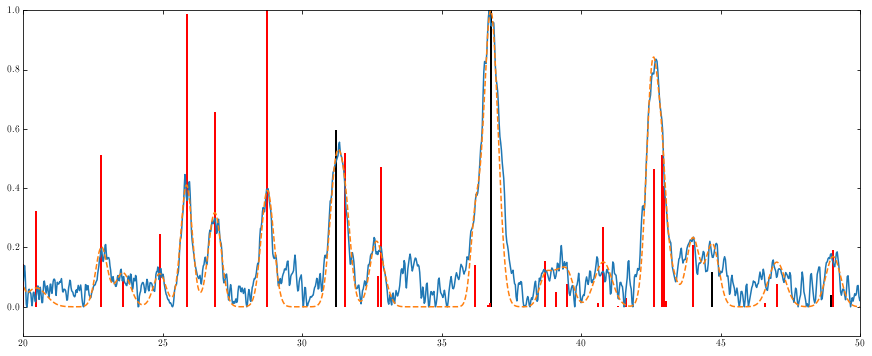

In [618]:
g_spinel_barite = GaussNewton([spinel,barite],xrd_spinel_barite)

for i in range(8):
    g_spinel_barite.minimize_gamma(alpha=1)
    g_spinel_barite.minimize_sigma(alpha=1)

for i in range(8):
    g_spinel_barite.calibration(alpha=1)

print(g_spinel_barite.sigma2)
print(g_spinel_barite.gamma)
    
figure(figsize=(15,6))

spinel.plot(colors='k',lw=2)
barite.plot(colors='r',lw=2)
xrd_spinel_barite.plot('-')

g_spinel_barite.plot('--')

xlim(20,50)
ylim(-0.1,1)

(-0.1, 1.0)

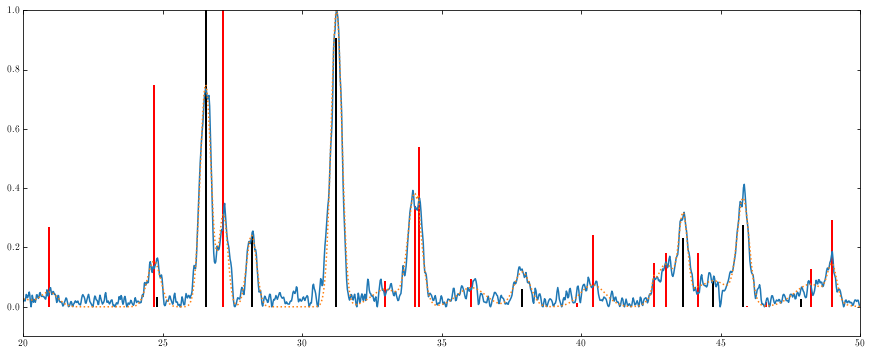

In [627]:
g_cinnabar_hydrocerussite = GaussNewton([hydrocerussite,cinnabar],xrd_cinnabar_hydrocerussite)
g_hydrocerussite = GaussNewton(hydrocerussite,xrd_cinnabar_hydrocerussite)

g_cinnabar_hydrocerussite.gamma[6] = 2

for i in range(8):
    g_cinnabar_hydrocerussite.minimize_gamma(alpha=1)
    g_cinnabar_hydrocerussite.minimize_sigma(alpha=1)

for i in range(8):
    g_cinnabar_hydrocerussite.calibration(alpha=1)

figure(figsize=(15,6))

cinnabar.plot(colors='k',lw=2)
hydrocerussite.plot(colors='r',lw=2)
xrd_cinnabar_hydrocerussite.plot('-')

g_cinnabar_hydrocerussite.plot(':')

xlim(20,50)
ylim(-0.1,1)

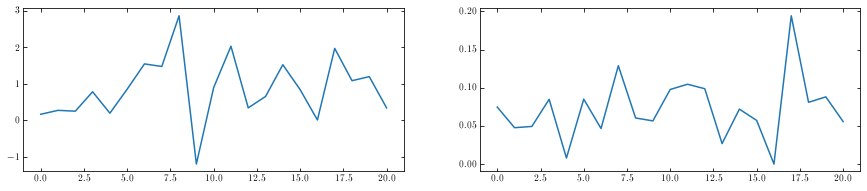

In [625]:
fig,ax = subplots(1,2,figsize=(15,3))
ax[0].plot(g_cinnabar_hydrocerussite.gamma)
ax[1].plot(g_cinnabar_hydrocerussite.sigma2)

(-0.1, 1.0)

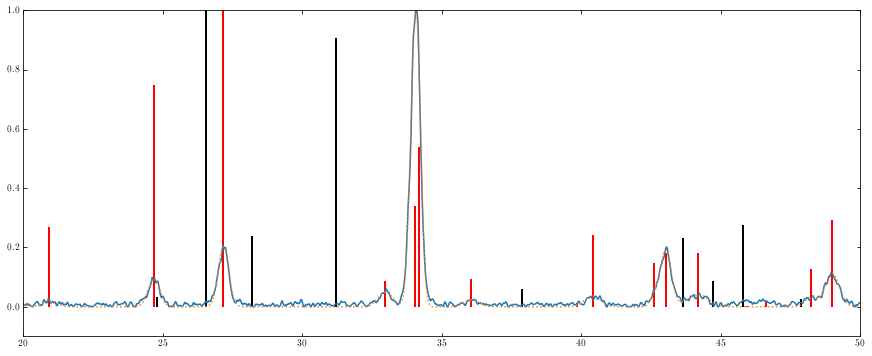

In [626]:
g_hydrocerussite = GaussNewton(hydrocerussite,xrd_hydrocerussite)

g_hydrocerussite.gamma[6] = 2

for i in range(8):
    g_hydrocerussite.minimize_gamma(alpha=1)
    g_hydrocerussite.minimize_sigma(alpha=1)

for i in range(8):
    g_hydrocerussite.calibration(alpha=1)

figure(figsize=(15,6))

cinnabar.plot(colors='k',lw=2)
hydrocerussite.plot(colors='r',lw=2)
xrd_hydrocerussite.plot('-')

g_hydrocerussite.plot(':')

xlim(20,50)
ylim(-0.1,1)